# CNN

Alunos:

Arthur Wanderley Ferreira dos Santos - awfs@cesar.school

Thiago Wanderley Amorim - twa@cesar.school

## 1. Leitura dos dados

In [ ]:
# Importando bibliotecas necessárias
import os
import shutil
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Acessa repositório no github para obter o dataset
!git clone https://github.com/arthurwanderley/topicos_contemporaneos.git

#Caminho do dataset
dataset_path = "topicos_contemporaneos/Trabalho Final CNN/homer_bart_1"

# Listando as imagens no dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith("bmp")]

Cloning into 'topicos_contemporaneos'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 281 (delta 220), reused 278 (delta 219), pack-reused 0 (from 0)
Receiving objects: 100% (281/281), 7.72 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (220/220), done.


Definição de Transformações e Data Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar as imagens
    transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
    transforms.RandomRotation(15),  # Rotação aleatória
    transforms.ToTensor(),  # Converter para tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalização
])

Preparação dos dados

In [ ]:
# Preparando os dados
images = []
labels = []

for img_file in image_files:
    img_path = os.path.join(dataset_path, img_file)
    img = Image.open(img_path)
    tensor_img = transform(img)
    images.append(tensor_img)

    if "homer" in img_file.lower():
        labels.append(0)  # Classe 0 para Homer
    elif "bart" in img_file.lower():
        labels.append(1)  # Classe 1 para Bart

images = torch.stack(images)
labels = torch.tensor(labels)

In [ ]:
print("Amostras do dataset:", images.size(0))
print("\nDimensões dos dados das imagens:   ", images.size())
print("Valores mínimo e máximo dos pixels:", torch.min(images), torch.max(images))
print("Tipo dos dados das imagens:        ", type(images))
print("Tipo das classes das imagens:      ", type(labels))

Amostras do dataset: 269

Dimensões dos dados das imagens:    torch.Size([269, 3, 128, 128])
Valores mínimo e máximo dos pixels: tensor(-1.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


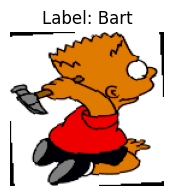

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(images[0].permute(1, 2, 0))
plt.title(f"Label: {'Homer' if labels[0] == 0 else 'Bart'}")
plt.axis('off')
plt.show()

Criação do dataset

In [ ]:
# Criando o dataset completo
dataset = TensorDataset(images, labels)

In [ ]:
# Dividindo o dataset em treino (80%) e validação (20%)
data_size = len(dataset)
train_size = int(0.8 * data_size)
val_size = data_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Modelo Pré Treinado - Resnet18

In [ ]:
from torchvision import models

In [ ]:
# Carregando um modelo pré-treinado (ResNet18 como exemplo)
model_resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.2MB/s]


In [ ]:
# Congelando as camadas do modelo pré-treinado
for param in model_resnet.parameters():
    param.requires_grad = False

# Substituindo a camada final para se ajustar ao número de classes do dataset
num_classes = 2
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, num_classes)

In [ ]:
# Configuração do dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

### Modelo CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Alterado para 3 canais de entrada (RGB)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 29 * 29, 64)  # Ajustado para tamanhos de entrada 128x128
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_cnn = CNN().to(device)

## 2. Treinamento

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def treinar_modelo(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if (epoch % 10) == 0:
          print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    print("Treinamento concluído!")

In [ ]:
def validar_modelo(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= total
    accuracy = 100 * correct / total
    print('\nConjunto de Validação: Loss médio: {:.4f}, Acurácia: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total, accuracy))

In [ ]:
# Treinamento Resnet18
print("Treinando o modelo ResNet18...")
treinar_modelo(model_resnet, train_loader, val_loader, criterion, optimizer_resnet, 50)
print("Validando o modelo ResNet18...")
validar_modelo(model_resnet, val_loader)

Treinando o modelo ResNet18...
Epoch 1/50, Loss: 0.7262
Epoch 2/50, Loss: 0.5840
Epoch 3/50, Loss: 0.4451
Epoch 4/50, Loss: 0.3605
Epoch 5/50, Loss: 0.3105
Epoch 6/50, Loss: 0.2751
Epoch 7/50, Loss: 0.2399
Epoch 8/50, Loss: 0.2116
Epoch 9/50, Loss: 0.1994
Epoch 10/50, Loss: 0.2642
Epoch 11/50, Loss: 0.1869
Epoch 12/50, Loss: 0.1845
Epoch 13/50, Loss: 0.1809
Epoch 14/50, Loss: 0.2099
Epoch 15/50, Loss: 0.1584
Epoch 16/50, Loss: 0.1597
Epoch 17/50, Loss: 0.1602
Epoch 18/50, Loss: 0.1511
Epoch 19/50, Loss: 0.1435
Epoch 20/50, Loss: 0.1444
Epoch 21/50, Loss: 0.1297
Epoch 22/50, Loss: 0.1319
Epoch 23/50, Loss: 0.1368
Epoch 24/50, Loss: 0.1352
Epoch 25/50, Loss: 0.1357
Epoch 26/50, Loss: 0.2216
Epoch 27/50, Loss: 0.1355
Epoch 28/50, Loss: 0.1182
Epoch 29/50, Loss: 0.1032
Epoch 30/50, Loss: 0.1079
Epoch 31/50, Loss: 0.1390
Epoch 32/50, Loss: 0.1129
Epoch 33/50, Loss: 0.1013
Epoch 34/50, Loss: 0.0957
Epoch 35/50, Loss: 0.1213
Epoch 36/50, Loss: 0.0938
Epoch 37/50, Loss: 0.0857
Epoch 38/50, Los

In [ ]:
# Treinando e validando o modelo CNN personalizado
print("Treinando o modelo CNN personalizado...")
treinar_modelo(model_cnn, train_loader, val_loader, criterion, optimizer_cnn,100)
print("Validando o modelo CNN personalizado...")
validar_modelo(model_cnn, val_loader)

Treinando o modelo CNN personalizado...
Epoch 1/100, Loss: 0.0022
Epoch 11/100, Loss: 0.0019
Epoch 21/100, Loss: 0.0016
Epoch 31/100, Loss: 0.0013
Epoch 41/100, Loss: 0.0012
Epoch 51/100, Loss: 0.0011
Epoch 61/100, Loss: 0.0010
Epoch 71/100, Loss: 0.0009
Epoch 81/100, Loss: 0.0008
Epoch 91/100, Loss: 0.0007
Treinamento concluído!
Validando o modelo CNN personalizado...

Conjunto de Validação: Loss médio: 0.0387, Acurácia: 41/54 (76%)

